# Molecule mapping of the $\beta$ Pictoris system

In this tutorial we will simulate an observation of the $\beta$ Pictoris system with a Medium-Resolution Integral Field Spectrograph similar to VLT/SINFONI or VLT/ERIS. After simulating the observation we will detect both planets using the molecular mapping technique from Hoeijmakers et al. 2018.

In [1]:
#------ manually fix import
import sys
import os
import pathlib

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path)
#------

import hcipy as hp
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from ObservationSimulator import *
from scipy.ndimage import gaussian_filter1d

First, we define the wavelength grid that we observe. In our case, we simulate the wavelength sampling of K-band setting of VLT/SINFONI.

In [2]:
spectral_resolution = 5000
wavelengths = np.arange(1.929, 2.472, 0.25e-3)*u.micron

## Sources
Now we have to define the sources that we observe. Here, we simulate a star with the properties of beta pictoris and the two planets. We also include the sky background, as that may be important in the K-band.

In [3]:
#Star
star = Star(wavelengths, distance=19.44*u.pc, radius=1.8*u.R_sun,
            mass=1.75*u.M_sun, radial_velocity=20*u.km/u.s, temperature=8000*u.K)

#Planets
beta_pic_b = Planet(wavelengths, host=star, orbital_phase=-np.pi/4*u.rad, 
                    sma=9.9*u.au, radius=1.46*u.R_jup, inclination=90*u.deg, temperature=1700*u.K)

beta_pic_c = Planet(wavelengths, host=star, orbital_phase=np.pi/2*u.rad, 
                    sma=2.7*u.au, radius=1.2*u.R_jup, inclination=90*u.deg, temperature=1200*u.K)

#Sky background
sky_background = Background(wavelengths)
sky_spec = get_sky_emission(fov=0.8*u.arcsec)
sky_background.spectral_model = InterpolatedSpectrum(sky_spec.wavelengths, sky_spec, 
                                                     spectral_resolution=spectral_resolution)

Now we define the spectral models of the star and the plane. We use a PHOENIX spectrum for the star and BT-Settl models for the planets.

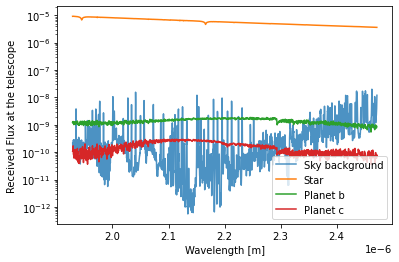

In [4]:
star_spec = get_PHOENIX_spectrum(temperature=star.temperature, log_g=4)
star.spectral_model = InterpolatedSpectrum(star_spec.wavelengths, star_spec, spectral_resolution=spectral_resolution)


beta_pic_b_spec = get_BT_SETTL_spectrum(temperature = beta_pic_b.temperature, log_g=4)
beta_pic_b.spectral_model = InterpolatedSpectrum(beta_pic_b_spec.wavelengths, beta_pic_b_spec,
                                                 spectral_resolution=spectral_resolution)

beta_pic_c_spec = get_BT_SETTL_spectrum(temperature = beta_pic_c.temperature, log_g=4)
beta_pic_c.spectral_model = InterpolatedSpectrum(beta_pic_c_spec.wavelengths, beta_pic_c_spec,
                                                 spectral_resolution=spectral_resolution)

plot_spectrum(sky_background.spectrum, label='Sky background', alpha = 0.8)
plot_spectrum(star.spectrum, label='Star')
plot_spectrum(beta_pic_b.spectrum, label='Planet b')
plot_spectrum(beta_pic_c.spectrum, label='Planet c')

plt.yscale('log')
plt.ylabel('Received Flux at the telescope')
plt.xlabel('Wavelength [m]')
plt.legend()
plt.show()

## Instrument

Next, we define our instrument.

In [41]:
#------------Define instrument---------
fov = 0.5*u.arcsec
read_noise = 7
dark_current_rate = 0.05 * u.Hz
telescope = Telescope(diameter=8*u.m, field_of_view=fov, pupil_grid_size=64, focal_grid_size=32)

input_pup = hcipyPupilGenerator(telescope)
x = input_pup
x = AtmosphericTransmission(wavelengths)(input_pup)
x = EffectiveThroughput(0.1)(x)
x = telescope.aperture()(x)

x = Atmosphere(seeing=0.9*u.arcsec, tau_0=0.005*u.s, L0=40*u.m, N_layers=3)(x)
x = IdealAO(num_modes=60, mode_basis='actuators', noise_level=400*u.nm)(x)
x = telescope.propagator()(x)

#We make use of the Detector3D wrapper, which basically acts as a seperate detector at each wavelength.
detector = PhysicalDetector(read_noise=read_noise, dark_current_rate=dark_current_rate
                                      ,well_depth=np.inf, gain=1, quantum_efficiency=0.8)
ifs = Detector3D(detector, wavelengths)(x)

And then we run the simulation.

In [49]:
#---------Run simulation-----------------
sim = Simulation(first_component=input_pup)

DIT = 4*60*u.s
N_DIT = 10
time_resolution = 4*60*u.s
for x in range(N_DIT):
    print('Simulating exoposure {0}/{1}'.format(x, N_DIT))
    sim.run([star, beta_pic_b, beta_pic_c], observing_time=DIT, time_resolution=time_resolution)
    if x==0:
        datacube = ifs.read_out(destructive=True)
    else:
        datacube += ifs.read_out(destructive=True)

  0%|          | 0/1 [00:00<?, ?it/s]

Simulating exoposure 0/10


  0%|          | 0/1 [00:00<?, ?it/s]

Simulating exoposure 1/10


  0%|          | 0/1 [00:00<?, ?it/s]

Simulating exoposure 2/10


  0%|          | 0/1 [00:00<?, ?it/s]

Simulating exoposure 3/10


  0%|          | 0/1 [00:00<?, ?it/s]

Simulating exoposure 4/10


  0%|          | 0/1 [00:00<?, ?it/s]

Simulating exoposure 5/10


  0%|          | 0/1 [00:00<?, ?it/s]

Simulating exoposure 6/10


  0%|          | 0/1 [00:00<?, ?it/s]

Simulating exoposure 7/10


  0%|          | 0/1 [00:00<?, ?it/s]

Simulating exoposure 8/10


  0%|          | 0/1 [00:00<?, ?it/s]

Simulating exoposure 9/10


100%|██████████| 1/1 [00:22<00:00, 22.91s/it]


In [55]:
sim.statistics()

np.save('/users/ricolandman/Documents/Research/MedRes/Simulations/sinfoni_like_beta_pic.npy', datacube)

Total runtime: 23.3 s.
Time spent on overhead: -160 s.
----------
Time spent per component:
	<ObservationSimulator.simulation.components_hcipy.hcipyPupilGenerator object at 0x1357f45b0>:	16.6 s
	<ObservationSimulator.simulation.atmosphere.AtmosphericTransmission object at 0x1357f4130>:	17.7 s
	<ObservationSimulator.simulation.atmosphere.EffectiveThroughput object at 0x140642a30>:	2.81 s
	<ObservationSimulator.simulation.components_hcipy.Apodizer object at 0x1470d4d90>:	8.98 s
	<ObservationSimulator.simulation.atmosphere.Atmosphere object at 0x1355affa0>:	6.78 s
	<ObservationSimulator.simulation.ao.IdealAO object at 0x14654b5e0>:	17.5 s
	<ObservationSimulator.simulation.components_hcipy.FraunhoferPropagator object at 0x135459310>:	105 s
	<ObservationSimulator.simulation.detector.Detector3D object at 0x1354596a0>:	7.23 s


## Results
We can then read out the detectors and plot for example the broadband image.

[[4051765.86945263 4245177.41097001 4436963.58726139 ... 4736518.2504104
  4604384.58496592 4310411.10247798]
 [3710948.33391212 3946514.79092023 4273816.40501663 ... 4702018.61167024
  4600049.86337742 4372461.89337557]
 [3304864.24150782 3498828.27780148 3853578.0829894  ... 4571151.89849611
  4538799.61382801 4410062.71646856]
 ...
 [4499127.0559773  4511623.34894653 4590106.8204693  ... 3307737.77780764
  3449785.53999612 3577776.91827851]
 [4345484.38041244 4424144.9395436  4511329.60245116 ... 3140671.11181435
  3267643.91753326 3336856.02177418]
 [4238713.92046972 4343340.8975472  4363733.12628636 ... 3279144.63823972
  3374286.30385627 3403542.50832658]]


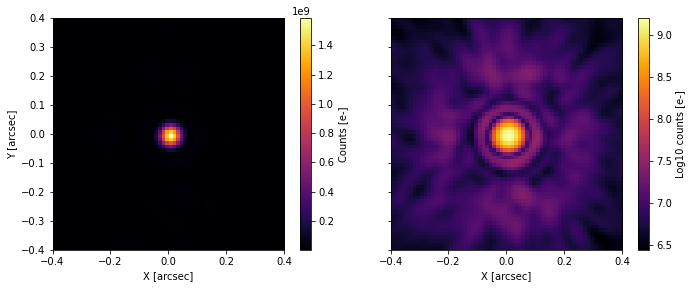

In [56]:
if not isinstance(fov, float):
    fov = fov.value
broadband_image = np.sum(datacube, axis=0)

#strehl = broadband_image.max()/diff_lim_image.max()
#print('Strehl ratio:', strehl)
fig, axes = plt.subplots(1,2,sharey=True, sharex=True, figsize=(10,4))
plt.sca(axes[0])
plt.imshow(broadband_image, cmap='inferno', extent=[-fov, fov, -fov, fov])
plt.ylabel('Y [arcsec]')
plt.xlabel('X [arcsec]')  
plt.colorbar(label='Counts [e-]')

print(broadband_image)
plt.sca(axes[1])
plt.imshow(np.log10(broadband_image), cmap='inferno', extent=[-fov, fov, -fov, fov])
plt.xlabel('X [arcsec]')  
plt.colorbar(label='Log10 counts [e-]')
plt.tight_layout()
plt.show()

## Data Analysis
Here, we apply the Molecule mapping technique from Hoeijmakers et al. 2018, where a template spectrum is cross-correlated with the datacube.

In [57]:
def molecule_mapping(datacube, wavelengths, N_pca, template, rv_grid, smoothing_kernel_width=30, exclude_rv=1000):
    #Find brightest spaxels
    tot_image = np.sum(datacube,axis=0)
    pixel_brightness_sorted = np.argsort(tot_image.ravel())[::-1]
    
    reshaped_cube = datacube.reshape(datacube.shape[0],-1)
    brightest_pix = np.argsort(np.sum(reshaped_cube.ravel(),axis=0))[::-1][:20]

    #Normalize
    norm_cube = reshaped_cube/np.nansum(reshaped_cube,axis=0)

    #Construct master spectrum and divide by it
    brightest_spec = norm_cube[:,brightest_pix]
    master_spec = np.median(brightest_spec,axis=1)
    stellar_normalised = (norm_cube.T/master_spec).T

    #Remove low-pass filtered version of appropriate master spectrum
    data_kernel_width = smoothing_kernel_width
    low_pass = np.array([gaussian_filter1d(spec, data_kernel_width) for spec in stellar_normalised.T]).T
    stellar_model = (low_pass.T*master_spec).T
    star_removed = norm_cube-stellar_model
    
    #PCA
    um,sm,vm =np.linalg.svd(star_removed, full_matrices=False)
    s_new = sm.copy()
    s_new[:N_pca] = 0
    pca_sub = (um.dot(np.diag(s_new))).dot(vm)
    
    #Molecule mapping
    beta = 1-rv_grid/3e5
    shifted_wavelengths = wavelengths * beta[:, np.newaxis]
    T = template.at(shifted_wavelengths.ravel()).reshape(shifted_wavelengths.shape).value
    
    cross_corr = T.dot(pca_sub)
    cross_corr -= np.nanmedian(cross_corr[np.abs(rv_grid)>exclude_rv],axis=0)
    cross_corr /= np.nanstd(cross_corr[np.abs(rv_grid)>exclude_rv],axis=0)

    reshaped_ccf_map = cross_corr.reshape(rv_grid.size, datacube.shape[1], datacube.shape[2])

    return reshaped_ccf_map

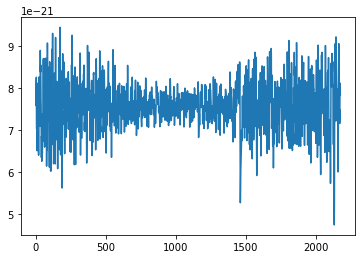

In [58]:
flat_model = convolve_to_resolution(beta_pic_b_spec, spectral_resolution)
continuum = gaussian_filter1d(flat_model, 30)
flat_model = flat_model/continuum
flat_model = InterpolatedSpectrum(flux_density=flat_model, wavelengths=flat_model.wavelengths)

flat_model.initialise_for(beta_pic_b)
plt.plot(flat_model.at(wavelengths))
plt.show()

Text(0.5, 0, 'Radial velocity [km/s]')

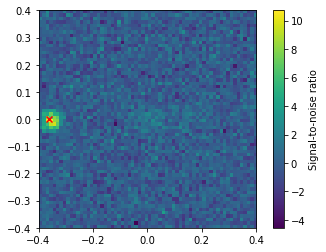

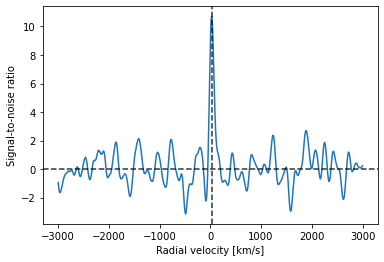

In [59]:
rv_grid = np.linspace(-3000,3000,500)
result= molecule_mapping(datacube, wavelengths, N_pca=5, template=flat_model,rv_grid = rv_grid)  

rv_idx = np.argmin(np.abs(rv_grid-beta_pic_b.radial_velocity.to(u.km/u.s).value))
plt.imshow(result[rv_idx],extent=[-fov, fov, -fov, fov])

idx = np.argmax(result[result.shape[0]//2+2])
plt.colorbar(label='Signal-to-noise ratio')
plt.scatter(*beta_pic_b.location.to(u.arcsec), marker='x',color='red' )
plt.figure()
plt.plot(rv_grid,result.reshape(result.shape[0],-1)[:,idx])
plt.axvline(beta_pic_b.radial_velocity.to(u.km/u.s).value, ls='--', color='black', alpha=0.8)
plt.axhline(0, ls='--', color='black', alpha=0.8)
plt.ylabel("Signal-to-noise ratio")
plt.xlabel("Radial velocity [km/s]")

Text(0.5, 0, 'Radial velocity [km/s]')

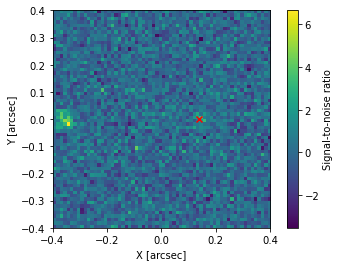

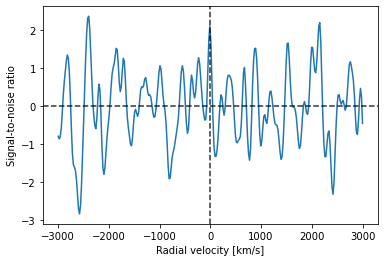

In [60]:
flat_model = convolve_to_resolution(beta_pic_c_spec, spectral_resolution)
continuum = gaussian_filter1d(flat_model, 30)
flat_model = flat_model/continuum
flat_model = InterpolatedSpectrum(flux_density=flat_model, wavelengths=flat_model.wavelengths)

flat_model.initialise_for(beta_pic_c)

rv_grid = np.linspace(-3000,3000,300)
result= molecule_mapping(datacube, wavelengths, N_pca=30, template=flat_model,rv_grid = rv_grid)  


rv_idx = np.argmin(np.abs(rv_grid-beta_pic_c.radial_velocity.to(u.km/u.s).value))
plt.imshow(result[rv_idx],extent=[-fov, fov, -fov, fov])
plt.xlabel('X [arcsec]')
plt.ylabel('Y [arcsec]')

offset = 11
idx = [result.shape[1]//2, result.shape[2]//2+offset]

plt.colorbar(label='Signal-to-noise ratio')
plt.scatter(*beta_pic_c.location.to(u.arcsec),marker='x', color='red')

plt.figure()
plt.plot(rv_grid, result[:,idx[0], idx[1]])
plt.axvline(beta_pic_c.radial_velocity.to(u.km/u.s).value, ls='--', color='black', alpha=0.8)
plt.axhline(0, ls='--', color='black', alpha=0.8)
plt.ylabel("Signal-to-noise ratio")
plt.xlabel("Radial velocity [km/s]")